# Comparison of parser results, Maltparser, default settings

This notebook will perform the same experiments as [the previous one](/notebooks/4.%20Analysis%20of%20parser%20results%20%28Mate%20tools%29.ipynb) for Mate tools, only instead using Maltparser run with default settings. We are also testing the entire UD 1.1 collection, instead of just looking at 1.0 as for Mate.

## Preprocessing

The conllu files had to be preprocessed to support the conllx format. This was done using the `tools/conllu2conllx.py` script. Thereafter the models were trained and tested with `tools/train_maltparser_default.py` and `tools/test_maltparser_default.py`.

#### Functional and content dependents
As specified in [A manual classification of dependency relations](/notebooks/3.%20A%20manual%20classification%20of%20dependency%20relations.ipynb)

- Functional dependents
- Content dependendents

#### Dependent classes as specified in the [UD documentation](http://universaldependencies.github.io/docs/u/dep/index.html)

- Classes expected to perform better than overall LAS for __synthetic__ languages:
  - __Core dependents of clausal predicates__: nsubj, csubj, nsubjpass, csubjpass, dobj, ccomp, xcomp, iobj
  - __Non-core dependents of clausal predicates__: nmod, advcl, advmod, neg
  - __Noun dependents, excluding _det_ and _neg___: nummod, acl, amod, appos, nmod
  - __Coordination, excluding _cc_ and _punct___: conj
  - 
- Classes expected to perform better than overall LAS for __isolated__ languages:
  - __Special clausal dependents__: vocative, aux, mark, discourse, auxpass, punct, expl, cop
  - __Case-marking, prepositions, possessive__: case


## Things to keep in mind when looking at the results

- Irish and Hungarian has fairly little data, and can't probably be trusted. 
- Czech has A LOT of data.

In [11]:
# My classes
content_dependents = ("acl", "advcl", "advmod", "amod", "appos", "ccomp", "compound", "conj", "csubj", "csubjpass", "dislocated", "dobj", "iobj", "list", "name", "nmod", "nsubj", "nsubjpass", "nummod", "parataxis", "remnant", "root", "vocative", "xcomp")
function_dependents = ('aux', 'auxpass', 'case', 'cc', 'cop', 'det', 'expl', 'mark', 'neg', 'mwe')
nonsemantic_dependents = ("punct", "discourse", "reparandum", "dep", "goeswith", "foreign")

# UD classes
core_dependents = ['nsubj', 'csubj', 'nsubjpass', 'csubjpass', 'dobj', 'ccomp', 'xcomp', 'iobj']
noncore_dependents = ['nmod', 'advcl', 'advmod', 'neg']
noun_dependents = ['nummod', 'acl', 'amod', 'appos', 'nmod']
coordination_dependents = ['conj']
special_clausal_dependents = ['vocative', 'aux', 'mark', 'discourse', 'auxpass', 'expl', 'cop']
other_functional_dependents = ['det', 'cc', 'case', 'mwe']

all_labels = content_dependents + function_dependents + nonsemantic_dependents

In [12]:
%matplotlib inline
import matplotlib
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 7.0)
matplotlib.style.use('ggplot')

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import sys, os
from os.path import join
sys.path.append("../tools/")
import udeval

import pandas as pd
import seaborn as sns
from collections import defaultdict

system_output_path = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/maltparser_output/"
gold_output_path = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/universaldependencies1-1/ud-treebanks-v1.1/"

system_output = {"UD_Basque": "UD_Basque.conllx",
                "UD_Croatian": "UD_Croatian.conllx",
                "UD_Danish": "UD_Danish.conllx",
                "UD_Finnish": "UD_Finnish.conllx",
                "UD_French": "UD_French.conllx",
                "UD_Greek": "UD_Greek.conllx",
                "UD_Hungarian": "UD_Hungarian.conllx",
                "UD_Irish": "UD_Irish.conllx",
                "UD_Persian": "UD_Persian.conllx",
                "UD_Swedish": "UD_Swedish.conllx",
                "UD_Bulgarian": "UD_Bulgarian.conllx",
                "UD_Czech": "UD_Czech.conllx",
                "UD_English": "UD_English.conllx",
                "UD_Finnish-FTB": "UD_Finnish-FTB.conllx",
                "UD_German": "UD_German.conllx",
                "UD_Hebrew": "UD_Hebrew.conllx",
                "UD_Indonesian": "UD_Indonesian.conllx",
                "UD_Italian": "UD_Italian.conllx",
                "UD_Spanish": "UD_Spanish.conllx"}

gold_file = {'UD_Basque': 'eu-ud-test.conllu',
            'UD_Croatian': 'hr-ud-test.conllu',
            'UD_Danish': 'da-ud-test.conllu',
            'UD_Finnish': 'fi-ud-test.conllu',
            'UD_French': 'fr-ud-test.conllu',
            'UD_Greek': 'el-ud-test.conllu',
            'UD_Hungarian': 'hu-ud-test.conllu',
            'UD_Irish': 'ga-ud-test.conllu',
            'UD_Persian': 'fa-ud-test.conllu',
            'UD_Swedish': 'sv-ud-test.conllu',
            'UD_Bulgarian': 'bg-ud-test.conllu',
            'UD_Czech': 'cs-ud-test.conllu',
            'UD_English': 'en-ud-test.conllu',
            'UD_Finnish-FTB': 'fi_ftb-ud-test.conllu',
            'UD_German': 'de-ud-test.conllu',
            'UD_Hebrew': 'he-ud-test.conllu',
            'UD_Indonesian': 'id-ud-test.conllu',
            'UD_Italian': 'it-ud-test.conllu',
            'UD_Spanish': 'es-ud-test.conllu'}

In [13]:
def labeled_attachment_scores():
    las = {}
    for lang in system_output.keys():
        s_out =  join(system_output_path, system_output[lang])
        g_out = join(gold_output_path, lang, gold_file[lang])
        score = udeval.attachment_score(s_out, g_out, labeled=True)
        las[lang] = score
    return pd.Series(las)
        
def precision_recall_filter_labels(labels):
    prec_recs = {"precision": [], "recall": []}
    index = []
    for lang in system_output.keys():
        s_out =  join(system_output_path, system_output[lang])
        g_out = join(gold_output_path, lang, gold_file[lang])
        precision, recall = udeval.labels_precision_recall(s_out, 
                                                           g_out, 
                                                           labels=labels)
        index.append(lang)
        prec_recs["precision"].append(precision)
        prec_recs["recall"].append(recall)

    return pd.DataFrame(prec_recs, index=index).sort_values("precision")

In [14]:
labeled_attachment_scores()

UD_Basque         0.231615
UD_Bulgarian      0.836466
UD_Croatian       0.355879
UD_Czech          0.768428
UD_Danish         0.274607
UD_English        0.796900
UD_Finnish        0.593545
UD_Finnish-FTB    0.784620
UD_French         0.488628
UD_German         0.252634
UD_Greek          0.719654
UD_Hebrew         0.562392
UD_Hungarian      0.206239
UD_Indonesian     0.408744
UD_Irish          0.624967
UD_Italian        0.823576
UD_Persian        0.645238
UD_Spanish        0.439358
UD_Swedish        0.753840
dtype: float64

In [15]:
all_labels_results = precision_recall_filter_labels(all_labels)
all_labels_results

,precision,recall
UD_Hungarian,0.206239,0.206239
UD_Basque,0.231615,0.231615
UD_German,0.252634,0.252634
UD_Danish,0.274607,0.274607
UD_Croatian,0.355879,0.355879
UD_Indonesian,0.408744,0.408744
UD_Spanish,0.439358,0.439358
UD_French,0.488628,0.488628
UD_Hebrew,0.563274,0.563274
UD_Finnish,0.593545,0.593545


In [16]:
label_result = dict()
for label in all_labels:
    label_result[label] = precision_recall_filter_labels([label])

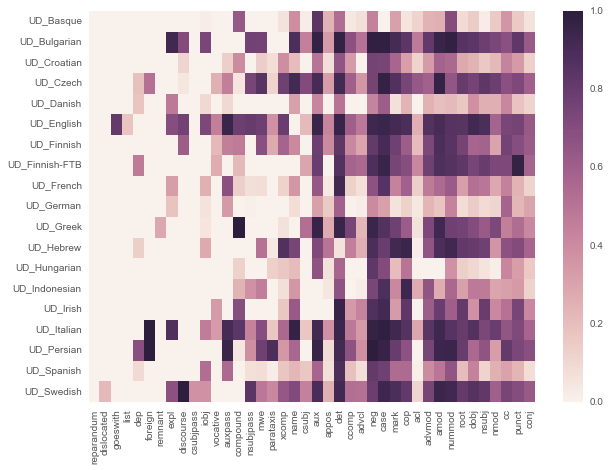

In [17]:
# Sort precision heatmap with languages according to standard ttr, 
# dependency labels according to cross-language entropy
dep_entropy = pd.Series.from_csv('../data/crosslingual_dependency_entropy.csv').index
dep_entropy = [label for label in dep_entropy if label != "subj"]  # remove hebrew bug
#sttr = ["fi", "cs", "de", "hu", "fr", "es", "ga", "sv", "it", "en"]
labels_precision = pd.DataFrame({y:x['precision'] for y,x in label_result.items()})
absolute_precision_scores = labels_precision[dep_entropy].fillna(0)
sns.heatmap(absolute_precision_scores)

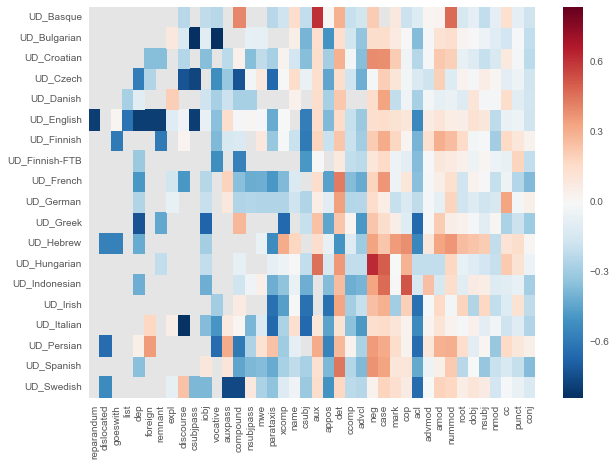

In [18]:
relative_precision_scores = labels_precision.subtract(all_labels_results['precision'], axis=0)[dep_entropy]
sns.heatmap(relative_precision_scores);

__TODO__: Analysis

# Performance for dependency classes

We calculate the precision and recall only using the labels classified as content relations. We then subtract the LAS to present how large of an increase (or reduction) in results the label class gets.

### Content and function relations

#### Absolute performance

In [19]:
content_dependents_result = precision_recall_filter_labels(content_dependents)
function_dependents_result = precision_recall_filter_labels(function_dependents)
results_dict = {"Content dependents": content_dependents_result, 
                "Function dependents": function_dependents_result}

content_function_results = pd.concat(results_dict.values(), keys=results_dict.keys(), axis=1)
content_function_results

Content dependents           Function dependents          
                        precision    recall           precision    recall
UD_Basque                0.147349  0.147349            0.570121  0.570121
UD_Bulgarian             0.791043  0.791043            0.931362  0.931362
UD_Croatian              0.278850  0.278850            0.578838  0.578838
UD_Czech                 0.753339  0.753339            0.864760  0.864760
UD_Danish                0.234455  0.234455            0.446332  0.446332
UD_English               0.746540  0.746540            0.918169  0.918169
UD_Finnish               0.535358  0.535358            0.765752  0.765752
UD_Finnish-FTB           0.749862  0.749862            0.795517  0.795517
UD_French                0.346909  0.346909            0.750092  0.750092
UD_German                0.140694  0.140694            0.436208  0.436208
UD_Greek                 0.661760  0.661760            0.862240  0.862240
UD_Hebrew                0.562171  0.562171            0.542353  0.542353
UD_Hungarian             0.066667  0.066667            0.542609  0.542609
UD_Indonesian            0.337228  0.337228            0.700297  0.700297
UD_Irish                 0.509208  0.509208            0.787589  0.787589
UD_Italian               0.751934  0.751934            0.934180  0.934180
UD_Persian               0.529140  0.529140            0.882340  0.882340
UD_Spanish               0.261212  0.261212            0.716320  0.716320
UD_Swedish               0.700817  0.700817            0.863404  0.863404

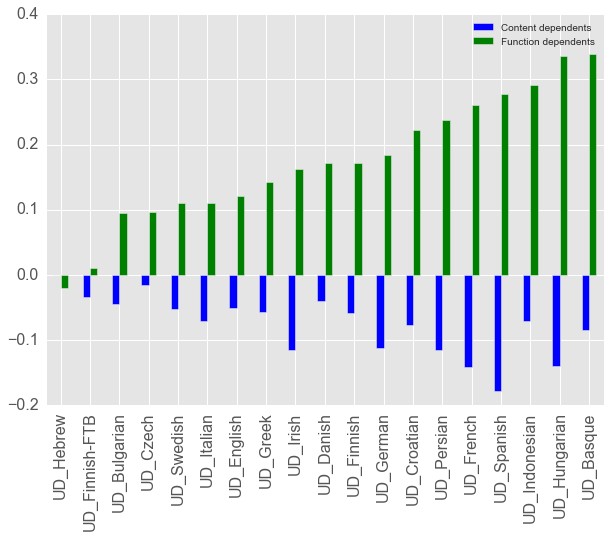

In [20]:
content_function_precisions = content_function_results.subtract(all_labels_results, level=1).xs('precision', level=1, axis=1)
content_function_precisions.sort_values('Function dependents').plot(kind='bar', fontsize=16)

In [21]:
core_dependent_result = precision_recall_filter_labels(core_dependents)
noncore_dependents_result = precision_recall_filter_labels(noncore_dependents)
noun_dependents_result = precision_recall_filter_labels(noun_dependents)
coordination_dependents_result = precision_recall_filter_labels(coordination_dependents)
special_clausal_dependents_result = precision_recall_filter_labels(special_clausal_dependents)
other_functional_dependents_result = precision_recall_filter_labels(other_functional_dependents)

ud_result_dict = {'Core': core_dependent_result,
                  'Noncore': noncore_dependents_result,
                  'Noun': noun_dependents_result,
                  'Coordination': coordination_dependents_result,
                  'Special clausal': special_clausal_dependents_result,
                  'Functionals': other_functional_dependents_result}

ud_class_result = pd.concat(ud_result_dict.values(), keys=ud_result_dict.keys(), axis=1)
ud_class_result

Core           Coordination           Special clausal  \
               precision    recall    precision    recall       precision   
UD_Basque       0.073382  0.073382     0.061224  0.061224        0.655316   
UD_Bulgarian    0.773453  0.773453     0.628842  0.628842        0.916071   
UD_Croatian     0.212062  0.212062     0.129353  0.129353        0.439614   
UD_Czech        0.778506  0.778506     0.599750  0.599750        0.779788   
UD_Danish       0.290685  0.290685     0.114155  0.114155        0.252588   
UD_English      0.864437  0.864437     0.630184  0.630184        0.909273   
UD_Finnish      0.563984  0.563984     0.624528  0.624528        0.699115   
UD_Finnish-FTB  0.752052  0.752052     0.579186  0.579186        0.742955   
UD_French       0.446469  0.446469     0.120690  0.120690        0.532584   
UD_German       0.089038  0.089038     0.303605  0.303605        0.216561   
UD_Greek        0.619824  0.619824     0.415888  0.415888        0.843407   
UD_Hebrew       0.708891  0.708891     0.570815  0.570815        0.875706   
UD_Hungarian    0.070796  0.070796     0.156522  0.156522        0.309091   
UD_Indonesian   0.413994  0.413994     0.122047  0.122047        0.611111   
UD_Irish        0.468278  0.468278     0.414634  0.414634        0.437008   
UD_Italian      0.726638  0.726638     0.574176  0.574176        0.904033   
UD_Persian      0.632164  0.632164     0.693512  0.693512        0.778667   
UD_Spanish      0.302761  0.302761     0.075758  0.075758        0.549915   
UD_Swedish      0.796551  0.796551     0.632458  0.632458        0.866155   

                              Noun           Functionals             Noncore  \
                  recall precision    recall   precision    recall precision   
UD_Basque       0.655316  0.214916  0.214916    0.434889  0.434889  0.170910   
UD_Bulgarian    0.916071  0.809328  0.809328    0.930849  0.930849  0.751675   
UD_Croatian     0.439614  0.331414  0.331414    0.646341  0.646341  0.236943   
UD_Czech        0.779788  0.822648  0.822648    0.891724  0.891724  0.717169   
UD_Danish       0.252588  0.224353  0.224353    0.546624  0.546624  0.264334   
UD_English      0.909273  0.647849  0.647849    0.915817  0.915817  0.667158   
UD_Finnish      0.699115  0.430346  0.430346    0.803347  0.803347  0.424857   
UD_Finnish-FTB  0.742955  0.759564  0.759564    0.825272  0.825272  0.740157   
UD_French       0.532584  0.333123  0.333123    0.796875  0.796875  0.341642   
UD_German       0.216561  0.151001  0.151001    0.492980  0.492980  0.175163   
UD_Greek        0.843407  0.720930  0.720930    0.864228  0.864228  0.709395   
UD_Hebrew       0.875706  0.461248  0.461248    0.487264  0.487264  0.404934   
UD_Hungarian    0.309091  0.037594  0.037594    0.551935  0.551935  0.044822   
UD_Indonesian   0.611111  0.310330  0.310330    0.710335  0.710335  0.390145   
UD_Irish        0.437008  0.431579  0.431579    0.874745  0.874745  0.463450   
UD_Italian      0.904033  0.778137  0.778137    0.937787  0.937787  0.780411   
UD_Persian      0.778667  0.474642  0.474642    0.915188  0.915188  0.370345   
UD_Spanish      0.549915  0.285002  0.285002    0.749628  0.749628  0.291902   
UD_Swedish      0.866155  0.641780  0.641780    0.865343  0.865343  0.647336   

                          
                  recall  
UD_Basque       0.170910  
UD_Bulgarian    0.751675  
UD_Croatian     0.236943  
UD_Czech        0.717169  
UD_Danish       0.264334  
UD_English      0.667158  
UD_Finnish      0.424857  
UD_Finnish-FTB  0.740157  
UD_French       0.341642  
UD_German       0.175163  
UD_Greek        0.709395  
UD_Hebrew       0.404934  
UD_Hungarian    0.044822  
UD_Indonesian   0.390145  
UD_Irish        0.463450  
UD_Italian      0.780411  
UD_Persian      0.370345  
UD_Spanish      0.291902  
UD_Swedish      0.647336

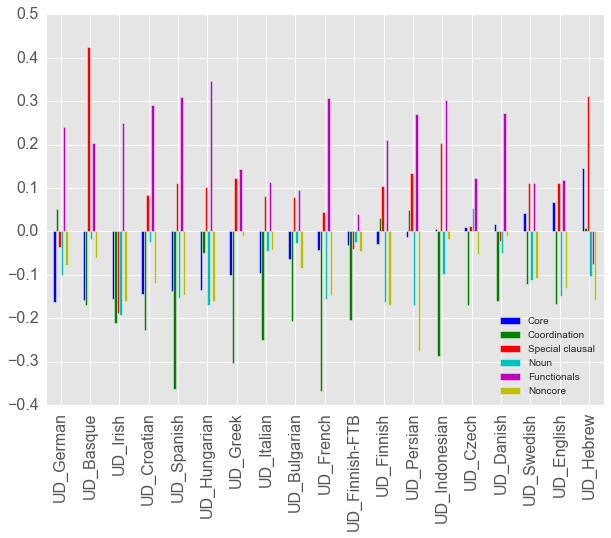

In [22]:
relative_ud_class_result = ud_class_result.subtract(all_labels_results, level=1).xs('precision', level=1, axis=1)
relative_ud_class_result.sort_values('Core').plot(kind='bar', fontsize=16)

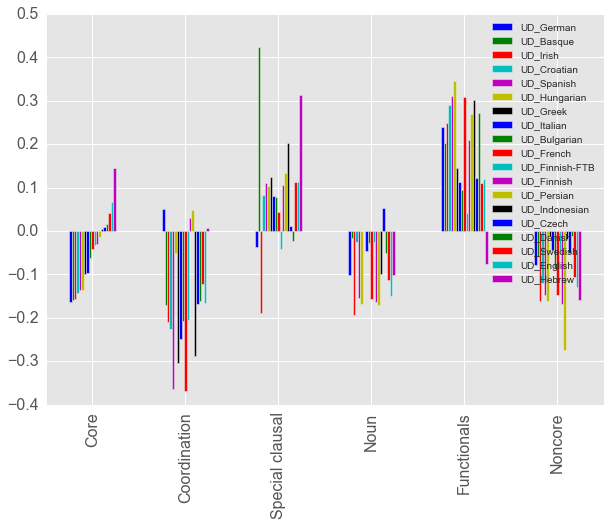

In [23]:
relative_ud_class_result.sort_values("Core").transpose().plot(kind='bar', fontsize=16)

In [24]:
add_order = [('core', core_dependents), 
             ('noun', noun_dependents), 
             ('non_core', noncore_dependents), 
             ('coord', coordination_dependents), 
             ('specl', special_clausal_dependents),
             ('functionals', other_functional_dependents)]


labels = []
cumul_results = []
cumul_name = ""
for class_name, label_class in add_order:
    labels += label_class
    labels_result = precision_recall_filter_labels(labels)
    cumul_name += "+" + class_name
    cumul_results.append((cumul_name, labels_result))

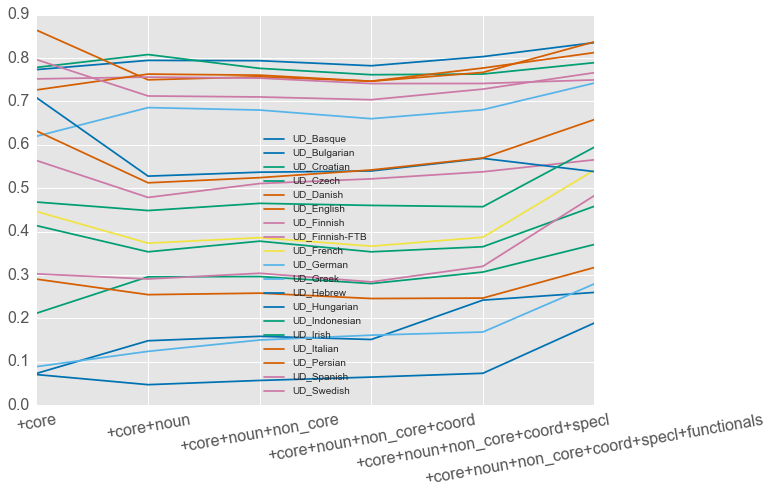

In [25]:
cmap1 = mpl.colors.ListedColormap(sns.color_palette("colorblind", 10))
pd.DataFrame([x[1]['precision'] for x in cumul_results], index=[x[0] for x in cumul_results]).plot(rot=10, fontsize=16, cmap=cmap1)

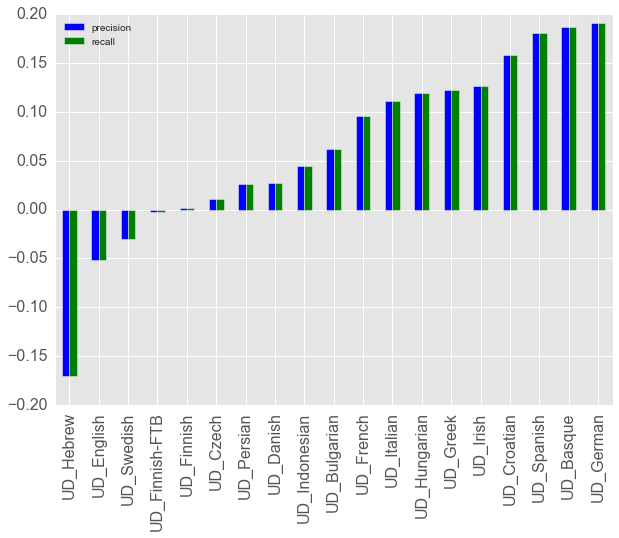

In [26]:
(cumul_results[-1][1] - cumul_results[0][1]).sort_values("precision").plot(kind='bar', fontsize=16)